# A. Pelabelan Sentimen

In [3]:
# 0. INSTALASI DAN IMPORT PUSTAKA
# =========================================
# Pastikan library terinstal. Jalankan di terminal jika belum:
# pip install pandas torch transformers[sentencepiece] accelerate nltk tqdm

import pandas as pd
import re
import nltk
import time
import sys
import warnings
from transformers import pipeline
from tqdm import tqdm # Import tqdm untuk progress bar

# --- untuk menyembunyikan peringatan ---
warnings.filterwarnings("ignore", message="The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers.")
# ----------------------------------------------------

# Mengunduh komponen NLTK untuk memecah kalimat.
try:
    nltk.data.find('tokenizers/punkt')
    print("✅ Tokenizer 'punkt' dari NLTK sudah tersedia.")
except LookupError:
    print("Mengunduh tokenizer 'punkt' dari NLTK...")
    nltk.download('punkt', quiet=True)
    print("✅ Download 'punkt' selesai.")

try:
    nltk.data.find('tokenizers/punkt_tab')
    print("✅ Tokenizer 'punkt_tab' dari NLTK sudah tersedia.")
except LookupError:
    print("Mengunduh tokenizer 'punkt_tab' dari NLTK...")
    nltk.download('punkt_tab', quiet=True)
    print("✅ Download 'punkt_tab' selesai.")

print("✅ Semua libraries berhasil dimuat.")

# =================================================
# 1. MEMUAT DATASET DAN KAMUS ASPEK
# =================================================
try:
    df_kamus = pd.read_csv('/kaggle/input/kamus-aspek-v5/kamus_aspek_v5.csv')
    df_ulasan = pd.read_csv('/kaggle/input/tokopedia/tokopedia_reviews_date_cleaned.csv')
    print("\n📂 File kamus dan kumpulan data ulasan berhasil dimuat.")
except FileNotFoundError as e:
    print(f"\n--- ERROR: File tidak ditemukan ---")
    print(f"Detail: {e}")
    print("PASTIKAN file 'kamus_sinonim_v2_diperluas.csv' dan 'tokopedia_reviews_new.csv' berada di folder yang sama.")
    sys.exit()

# ===================================================
# 2. MEMBANGUN KAMUS ASPEK (METODE EFISIEN)
# ===================================================
kamus_aspek = {}
for _, row in df_kamus.fillna('').iterrows():
    aspek = row['Aspek']
    kategori = row['Kategori']
    kata_kunci = [row['Kata Kunci']] + [row[f'Sinonim {i}'] for i in range(1, 7)]
    sinonim_bersih = [kata.strip().lower() for kata in kata_kunci if kata]

    if aspek not in kamus_aspek:
        kamus_aspek[aspek] = {"kategori": kategori, "sinonim": []}

    for sinonim in sinonim_bersih:
        if sinonim not in kamus_aspek[aspek]['sinonim']:
            kamus_aspek[aspek]['sinonim'].append(sinonim)

print(f"\n📚 Kamus aspek berhasil disusun: {len(kamus_aspek)} aspek terdeteksi.")

# =================================================
# 3. MEMPROSES DATA ULASAN
# =================================================
# <-- PERUBAHAN 1: Menambahkan 'Review Rating Overall' saat memilih kolom
pros = df_ulasan[['Review Pros', 'Review Date', 'Review Rating Overall']].dropna().rename(columns={'Review Pros': 'review'})
pros['asal_kolom'] = 'pros'
cons = df_ulasan[['Review Cons', 'Review Date', 'Review Rating Overall']].dropna().rename(columns={'Review Cons': 'review'})
cons['asal_kolom'] = 'cons'

df_long = pd.concat([pros, cons], ignore_index=True)
df_long = df_long[df_long['review'].str.strip() != '']
df_long['review'] = df_long['review'].astype(str).str.lower()
print(f"🗃️ Total {len(df_long)} ulasan berhasil disiapkan untuk diproses.")

# ====================================================
# 4. INISIALISASI MODEL DAN FUNGSI HELPER
# ====================================================
print("\n🔄 Memuat model ABSA: 'yangheng/deberta-v3-base-absa-v1.1'...")
absa_pipeline = None
try:
    absa_pipeline = pipeline(
        "text-classification",
        model="yangheng/deberta-v3-base-absa-v1.1",
        tokenizer="yangheng/deberta-v3-base-absa-v1.1",
        top_k=None,
        device=0,
        truncation=True,
        max_length=512
    )
    print("⚡ Model berhasil dimuat")
except Exception as e:
    print(f"\n--- GAGAL MEMUAT MODEL ---\nDetail Error: {e}")
    print("Pastikan koneksi internet stabil dan coba jalankan lagi.")
    sys.exit()

def ekstrak_aspek_dalam_kalimat(kalimat):
    hasil = []
    pattern_template = r'\b{}\b'
    for aspek, detail in kamus_aspek.items():
        for sinonim in detail['sinonim']:
            if re.search(pattern_template.format(re.escape(sinonim)), kalimat):
                hasil.append({
                    "aspek": aspek,
                    "kategori": detail['kategori'],
                    "match": sinonim
                })
                break
    return hasil

# ==================================================
# 5. PROSES UTAMA - BATCH PROCESSING VERSION
# ==================================================
start_time = time.time()
print("\n🚀 Memulai Analisis Sentimen Berbasis Aspek (ABSA) dengan Batch Processing...")

# --- TAHAP 1: PENGUMPULAN DATA ---
print("   > Tahap 1: Mengumpulkan semua input untuk diproses...")
inputs_to_process = []
metadata_for_inputs = []

# Iterasi untuk mengumpulkan semua data yang akan diproses
for i, row in tqdm(df_long.iterrows(), total=len(df_long), desc="Mengumpulkan data", unit="ulasan"):
    review_text = row['review']
    kalimat_list = nltk.sent_tokenize(review_text)

    for kalimat in kalimat_list:
        kalimat = kalimat.strip()
        if not kalimat:
            continue

        aspek_ditemukan = ekstrak_aspek_dalam_kalimat(kalimat)
        if not aspek_ditemukan:
            continue

        for aspek_info in aspek_ditemukan:
            input_absa = f"{kalimat} [SEP] {aspek_info['aspek']}"
            inputs_to_process.append(input_absa)
            
            # <-- PERUBAHAN 2: Menambahkan 'Rating Overall' ke dalam metadata
            metadata_for_inputs.append({
                "Review ID": i,
                "Tanggal Review": row['Review Date'],
                "Rating Overall": row['Review Rating Overall'], # <-- BARIS INI DITAMBAHKAN
                "Tipe Review": row['asal_kolom'],
                "Kalimat": kalimat,
                "Aspek": aspek_info['aspek'],
                "Kategori": aspek_info['kategori'],
                "Kata yang Cocok": aspek_info['match'],
                "Ulasan Lengkap": review_text
            })

print(f"   > Selesai. Total {len(inputs_to_process)} pasangan kalimat-aspek akan diproses.")

# --- TAHAP 2: PEMROSESAN BATCH & PENGGABUNGAN HASIL ---
print("   > Tahap 2: Memproses semua input dalam satu batch di GPU...")
hasil_akhir = []
pipeline_results = []

if inputs_to_process:
    try:
        pipeline_results = absa_pipeline(inputs_to_process, batch_size=16, truncation=True)
    except Exception as e:
        print(f"\n--- GAGAL MEMPROSES BATCH ---\nDetail Error: {e}", file=sys.stderr)
        sys.exit()

    for metadata, result in tqdm(zip(metadata_for_inputs, pipeline_results), total=len(metadata_for_inputs), desc="Menggabungkan hasil", unit="item"):
        scores = {item['label'].lower(): item['score'] for item in result}
        skor_pos = scores.get('positive', 0.0)
        skor_neg = scores.get('negative', 0.0)
        skor_neu = scores.get('neutral', 0.0)

        if skor_pos > skor_neg and skor_pos > skor_neu:
            sentimen_utama = 'positif'
        elif skor_neg > skor_pos and skor_neg > skor_neu:
            sentimen_utama = 'negatif'
        else:
            sentimen_utama = 'netral'

        final_entry = metadata.copy()
        final_entry.update({
            "Sentimen Utama": sentimen_utama,
            "Skor Positif": round(skor_pos, 4),
            "Skor Negatif": round(skor_neg, 4),
            "Skor Netral": round(skor_neu, 4)
        })
        hasil_akhir.append(final_entry)

end_time = time.time()
print(f"\n✅ Proses ABSA dengan Batch Processing selesai dalam {end_time - start_time:.2f} detik.")


# ============================================
# 6. TAMPILKAN DAN SIMPAN HASIL AKHIR
# ============================================
if hasil_akhir:
    # <-- PERUBAHAN 3: Menambahkan 'Rating Overall' ke urutan kolom
    kolom_urut = [
        "Review ID", "Tanggal Review", "Rating Overall", "Tipe Review", "Kalimat", 
        "Aspek", "Kategori", "Kata yang Cocok", "Sentimen Utama", "Skor Positif", 
        "Skor Negatif", "Skor Netral", "Ulasan Lengkap"
    ]
    df_hasil_final = pd.DataFrame(hasil_akhir)
    
    # Memastikan semua kolom yang diinginkan ada sebelum mengurutkan
    kolom_final_tersedia = [kol for kol in kolom_urut if kol in df_hasil_final.columns]
    df_hasil_final = df_hasil_final[kolom_final_tersedia]

    print("\n--- CONTOH 15 HASIL AKHIR ANALISIS (METODE BATCH PROCESSING) ---")
    print(df_hasil_final.head(15).to_string())

    nama_file_hasil = "hasil_absa_batch_processing.csv"
    df_hasil_final.to_csv(nama_file_hasil, index=False, encoding='utf-8-sig')
    print(f"\n✅ Semua hasil ({len(df_hasil_final)} baris) telah disimpan ke file '{nama_file_hasil}'")
else:
    print("\n--- TIDAK ADA ASPEK YANG DITEMUKAN ATAU TERJADI ERROR SAAT BATCH PROCESSING ---")

2025-06-26 19:00:21.295036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750964421.510990      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750964421.572882      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Tokenizer 'punkt' dari NLTK sudah tersedia.
✅ Tokenizer 'punkt_tab' dari NLTK sudah tersedia.
✅ Semua libraries berhasil dimuat.

📂 File kamus dan kumpulan data ulasan berhasil dimuat.

📚 Kamus aspek berhasil disusun: 13 aspek terdeteksi.
🗃️ Total 3584 ulasan berhasil disiapkan untuk diproses.

🔄 Memuat model ABSA: 'yangheng/deberta-v3-base-absa-v1.1'...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

Device set to use cuda:0


⚡ Model berhasil dimuat

🚀 Memulai Analisis Sentimen Berbasis Aspek (ABSA) dengan Batch Processing...
   > Tahap 1: Mengumpulkan semua input untuk diproses...


Mengumpulkan data: 100%|██████████| 3584/3584 [01:51<00:00, 32.05ulasan/s]


   > Selesai. Total 6148 pasangan kalimat-aspek akan diproses.
   > Tahap 2: Memproses semua input dalam satu batch di GPU...


Menggabungkan hasil: 100%|██████████| 6148/6148 [00:00<00:00, 184681.91item/s]


✅ Proses ABSA dengan Batch Processing selesai dalam 133.08 detik.

--- CONTOH 15 HASIL AKHIR ANALISIS (METODE BATCH PROCESSING) ---
    Review ID Tanggal Review  Rating Overall Tipe Review                                                               Kalimat                    Aspek   Kategori Kata yang Cocok Sentimen Utama  Skor Positif  Skor Negatif  Skor Netral                                                        Ulasan Lengkap
0           1     16-06-2025               5        pros       collaborative team, supporting each other with inspiring leader           Responsibility  Motivator          leader        positif        0.9932        0.0009       0.0059       collaborative team, supporting each other with inspiring leader
1           2     14-06-2025               4        pros                                good people culture growth opportunity              Advancement  Motivator     opportunity        positif        0.9947        0.0009       0.0045                       

# B. Analisis Hasil Sentimen

## 1. Data cleaning untuk agregasi nilai Δ Net-Score

In [4]:
import pandas as pd
from datetime import datetime

# 0. konfigurasi
CSV_SENTENCE = "/kaggle/working/hasil_absa_batch_processing.csv"

COL_ID       = "Review ID"
COL_DATE     = "Tanggal Review"
COL_ASPECT   = "Aspek"
COL_CATEGORY = "Kategori"
COL_SENTIMEN = "Sentimen Utama"
COL_RATING   = "Rating Overall"     # ganti jika kolom berbeda

ACQUISITION_DATE = datetime(2024, 5, 15)

ASPECTS = [
    "Achievement","Recognition","Work Itself","Responsibility","Growth","Advancement",
    "Compensation","Supervision","Work Condition","Interpersonal Relations",
    "Company Policy","Job Security","Personal Life"
]

# 1. load & data cleaning
df = pd.read_csv(CSV_SENTENCE)

df[COL_SENTIMEN] = df[COL_SENTIMEN].str.lower().str.strip()
df[COL_CATEGORY] = df[COL_CATEGORY].str.capitalize().str.strip()

df[COL_DATE] = pd.to_datetime(df[COL_DATE], format="%d-%m-%Y")
df["period"] = df[COL_DATE].apply(lambda d: "pre" if d < ACQUISITION_DATE else "post")

# 2. global flags 
df["pos_flag"] = (df[COL_SENTIMEN] == "positif").astype(int)
df["neg_flag"] = (df[COL_SENTIMEN] == "negatif").astype(int)

df["mot_pos_flag"] = ((df[COL_CATEGORY] == "Motivator") & (df["pos_flag"] == 1)).astype(int)
df["mot_neg_flag"] = ((df[COL_CATEGORY] == "Motivator") & (df["neg_flag"] == 1)).astype(int)
df["hyg_pos_flag"] = ((df[COL_CATEGORY] == "Hygiene")   & (df["pos_flag"] == 1)).astype(int)
df["hyg_neg_flag"] = ((df[COL_CATEGORY] == "Hygiene")   & (df["neg_flag"] == 1)).astype(int)

# 3. per-aspek flags 
for asp in ASPECTS:
    df[f"pos_{asp}"] = ((df[COL_ASPECT] == asp) & (df["pos_flag"] == 1)).astype(int)
    df[f"neg_{asp}"] = ((df[COL_ASPECT] == asp) & (df["neg_flag"] == 1)).astype(int)

# 4. agregasi review-level 
agg_dict = {
    "period"        : ("period", "first"),
    "rating"        : (COL_RATING, "first"),
    "motivator_pos" : ("mot_pos_flag", "sum"),
    "motivator_neg" : ("mot_neg_flag", "sum"),
    "hygiene_pos"   : ("hyg_pos_flag", "sum"),
    "hygiene_neg"   : ("hyg_neg_flag", "sum"),
}

for asp in ASPECTS:
    agg_dict[f"pos_{asp}"] = (f"pos_{asp}", "sum")
    agg_dict[f"neg_{asp}"] = (f"neg_{asp}", "sum")

df_review = (
    df.groupby(COL_ID)
      .agg(**agg_dict)
      .reset_index()
)

# 5. simpan
OUTPUT = "reviews_tokopedia.csv"
df_review.to_csv(OUTPUT, index=False)
print(f"✓ Berhasil: {OUTPUT} (rows = {len(df_review)})")


✓ Berhasil: reviews_tokopedia.csv (rows = 2920)


## 2. Kalkulasi two-proportion z-test, visualisasi perubahan sentimen positif, dan Priority Grid 


=== TOP Δ Aspects (saved → top6_table.csv) ===
            Aspect  Delta_pp     z       p
6     Compensation      10.2  2.21  0.0273
10  Company Policy       5.4  0.74  0.4595
1      Recognition       3.5  0.24  0.8115
4           Growth     -13.0 -2.44  0.0146
0      Achievement     -23.5 -1.29  0.1985
5      Advancement     -27.4 -4.72  0.0000

✓ Grafik tersimpan: delta_bar.png  |  priority_grid.png
✓ Full stats → all_aspect_stats.csv


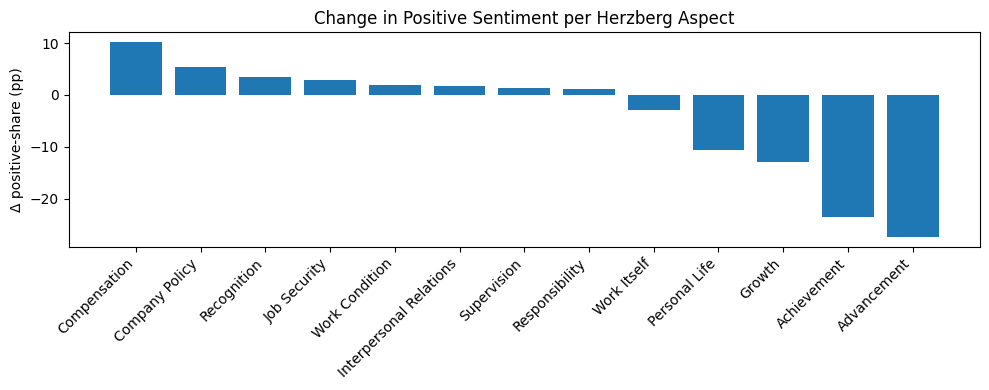

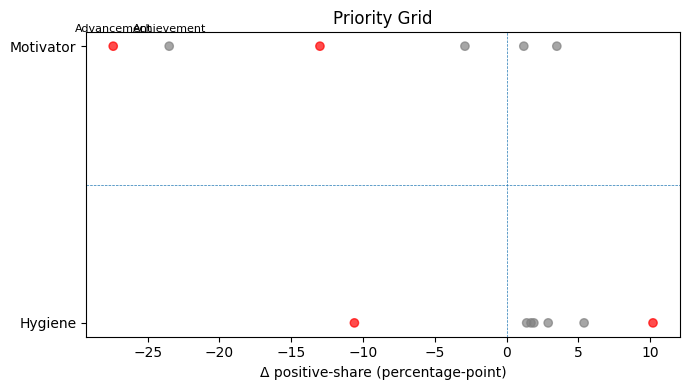

In [5]:
# 0. import library
import pandas as pd, numpy as np, math, matplotlib.pyplot as plt
from scipy.stats import norm

CSV = "/kaggle/working/reviews_tokopedia.csv"      # aggregated review-level data
ASPECTS = [                       # 13 aspek Herzberg
    "Achievement","Recognition","Work Itself","Responsibility","Growth","Advancement",
    "Compensation","Supervision","Work Condition","Interpersonal Relations",
    "Company Policy","Job Security","Personal Life"
]
# 1. load & split
df   = pd.read_csv(CSV)
pre  = df[df["period"]=="pre"]
post = df[df["period"]=="post"]

# 2. helper: z-test two proportions
def z_test(pos_pre, neg_pre, pos_post, neg_post):
    p1,n1 = pos_pre/(pos_pre+neg_pre), pos_pre+neg_pre
    p2,n2 = pos_post/(pos_post+neg_post), pos_post+neg_post
    p  = (pos_pre+pos_post)/(n1+n2)
    z  = (p2-p1)/math.sqrt(p*(1-p)*(1/n1+1/n2))
    pval = 2*(1-norm.cdf(abs(z)))
    return z, pval

# 3. loop aspek 
rows=[]
for asp in ASPECTS:
    pos_pre  = pre[f"pos_{asp}"].sum();  neg_pre  = pre[f"neg_{asp}"].sum()
    pos_post = post[f"pos_{asp}"].sum(); neg_post = post[f"neg_{asp}"].sum()
    if (pos_pre+neg_pre)==0 or (pos_post+neg_post)==0: continue  # skip empty
    p_pre  = pos_pre /(pos_pre+neg_pre )
    p_post = pos_post/(pos_post+neg_post)
    delta  = p_post-p_pre
    z,pv   = z_test(pos_pre,neg_pre,pos_post,neg_post)
    cat    = "Motivator" if asp in [
        "Achievement","Recognition","Work Itself","Responsibility",
        "Growth","Advancement"
    ] else "Hygiene"
    rows.append(dict(Aspect=asp, Category=cat,
                     Pos_pre=round(p_pre*100,1),
                     Pos_post=round(p_post*100,1),
                     Delta_pp=round(delta*100,1),
                     z=round(z,2), p=round(pv,4)))

df_aspect = pd.DataFrame(rows).sort_values("Delta_pp", ascending=False)
df_aspect.to_csv("all_aspect_stats.csv", index=False)

# ------------- 4. pilih 3 Δ↑ & 3 Δ↓ terbesar -------------------------------
top_pos = df_aspect.head(3)
top_neg = df_aspect.tail(3)
top6    = pd.concat([top_pos, top_neg]).sort_values("Delta_pp", ascending=False)
top6.to_csv("top6_table.csv", index=False)
print("\n=== TOP Δ Aspects (saved → top6_table.csv) ===")
print(top6[["Aspect","Delta_pp","z","p"]])

# ------------- 5. bar chart Δ semua aspek -----------------------------------
plt.figure(figsize=(10,4))
plt.bar(df_aspect["Aspect"], df_aspect["Delta_pp"])
plt.xticks(rotation=45, ha="right"); plt.ylabel("Δ positive-share (pp)")
plt.title("Change in Positive Sentiment per Herzberg Aspect")
plt.tight_layout(); plt.savefig("delta_bar.png", dpi=300)

# ------------- 6. priority-grid scatter -------------------------------------
plt.figure(figsize=(7,4))
y_map = {"Motivator":1, "Hygiene":0}
colors = ["red" if row["p"]<0.05 else "gray" for _,row in df_aspect.iterrows()]
plt.scatter(df_aspect["Delta_pp"], df_aspect["Category"].map(y_map),
            c=colors, alpha=0.7)
for _,r in df_aspect.iterrows():
    if abs(r["Delta_pp"])>=max(abs(df_aspect["Delta_pp"]))*0.6:
        plt.text(r["Delta_pp"], y_map[r["Category"]]+0.05,
                 r["Aspect"], fontsize=8, ha="center")
plt.axhline(0.5, ls="--", lw=0.5); plt.axvline(0, ls="--", lw=0.5)
plt.yticks([0,1],["Hygiene","Motivator"])
plt.xlabel("Δ positive-share (percentage-point)"); plt.title("Priority Grid")
plt.tight_layout(); plt.savefig("priority_grid.png", dpi=300)

print("\n✓ Grafik tersimpan: delta_bar.png  |  priority_grid.png")
print("✓ Full stats → all_aspect_stats.csv")
